In [1]:
import os, cv2
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import segmentation_models as sm 
import seaborn as sns; sns.set()
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout,ZeroPadding2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import EfficientNetB0
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Segmentation Models: using `tf.keras` framework.


In [2]:
root_folder = './data/SemanticSegmentationDataset'

In [3]:
# cut images into 256x256 pieces
img_patch_size = 256

# Normalization => rescale each variable to the range of 0-1
scaler = MinMaxScaler()

In [4]:
img_dataset =[]

for path , subdirs, files in os.walk(root_folder):
    
    # name of each direcory
    dir_name = path.split(os.path.sep)[-1]
    
    if dir_name== 'images':
        print(path)
        
        # list of images in each 'image' directory
        images_lst = os.listdir(path)
        images_lst.sort()
        
        for i , img in enumerate(images_lst):
            if img.endswith('.jpg'): 
                print('-------------------\n' ,img)
                
                #read images
                image = cv2.imread(path+ '/' + img , 1)
                print(image.shape)
                
                # images are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (image.shape[1] // img_patch_size) * img_patch_size
                sizeY = (image.shape[0] // img_patch_size) * img_patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,sizeX,sizeY))
                print(image)
                
                # convert images into numpy array
                image = np.array(image)

                # cut up images into 256x256 pieces
                patched_imgs = patchify(image , (img_patch_size,img_patch_size,3) , step= img_patch_size)
                print(patched_imgs.shape)
                
                for i in range(patched_imgs.shape[0]):
                    for j in range(patched_imgs.shape[1]):
                        single_patch_img = patched_imgs[i,j,:,:]

                        # normalize images via MinMaxScaler => value between 0 and 1
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        
                        # add all patched images to a list
                        img_dataset.append(single_patch_img)

./data/SemanticSegmentationDataset\Tile 1\images
-------------------
 image_part_001.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F3DA1F50>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F0DBDD10>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8A87EC5D0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8A87CF2D0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F3DA1ED0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.jpg
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F3B19210>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.jpg
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F3B1

In [5]:
msk_dataset = [] 

for path, subdirs, files in os.walk(root_folder):

    # name of each direcory
    dirname = path.split(os.path.sep)[-1]
    
    if dirname == 'masks':
        print(path)
        
        # list of masks in each 'mask' directory
        masks_lst = os.listdir(path)
        masks_lst.sort()
        
        
        for i, msk in enumerate(masks_lst):  
            if msk.endswith(".png"):
                print('-------------------\n' ,msk)
               
                #Read each mask
                mask = cv2.imread(path+"/"+msk, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                print(mask.shape)
                
                # masks are cropped from their top and left corners to the nearest size that is divisible by 256
                sizeX = (mask.shape[1]//img_patch_size)*img_patch_size 
                sizeY = (mask.shape[0]//img_patch_size)*img_patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, sizeX, sizeY)) 
                print(mask)
                
                # convert masks into numpy array
                mask = np.array(mask)             
       
                # cut up masks into 256x256 pieces
                patched_masks = patchify(mask , (img_patch_size,img_patch_size,3) , step= img_patch_size)
                print(patched_masks.shape)
        
                for i in range(patched_masks.shape[0]):
                    for j in range(patched_masks.shape[1]):
                        
                        single_patch_mask = patched_masks[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]  
                        
                        # add all patched masks to a list
                        msk_dataset.append(single_patch_mask) 

./data/SemanticSegmentationDataset\Tile 1\masks
-------------------
 image_part_001.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F3D7E6D0>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_002.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F1C93D90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_003.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F1C93D90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_004.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F3D95B90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_005.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F1C93D90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_006.png
(643, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F1C93D90>
(2, 3, 1, 256, 256, 3)
-------------------
 image_part_007.png
(644, 797, 3)
<PIL.Image.Image image mode=RGB size=768x512 at 0x2C8F1C93

In [6]:
img_dataset = np.array(img_dataset)
msk_dataset =  np.array(msk_dataset)

In [7]:
print("Number of images : ", len(img_dataset))
print("Number of masks : ", len(msk_dataset))

Number of images :  1305
Number of masks :  1305


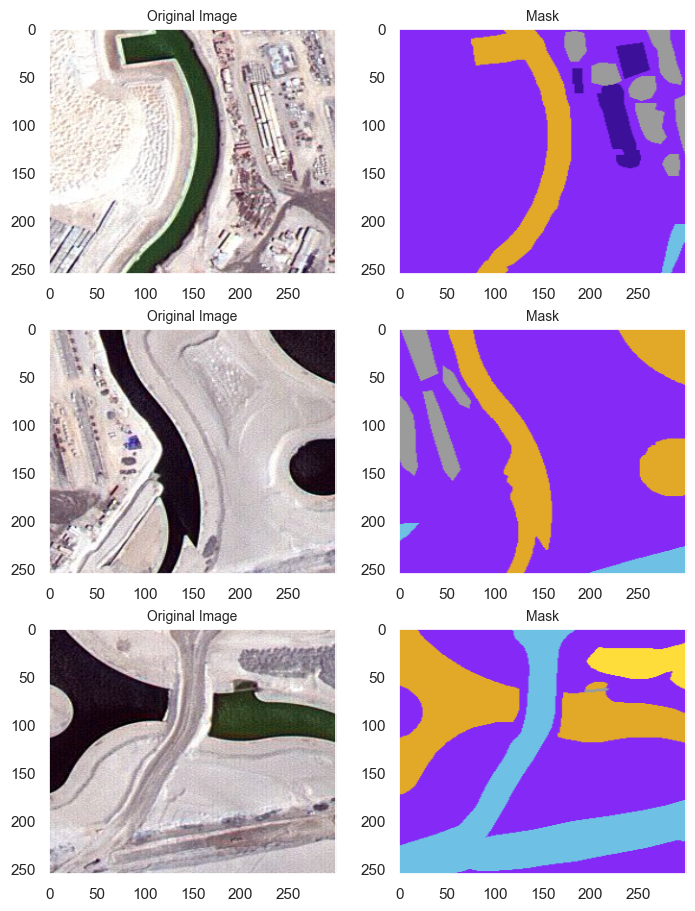

In [8]:
# Visualise patched images & their corresponding masks
count = 0
i = 0
fig, axs = plt.subplots(3, 2, figsize=(7, 9), constrained_layout=True)

for mask in msk_dataset:
    if (mask.all()):
        # read images
        axs[count][0].imshow(cv2.resize(img_dataset[i], (300,256)))
        axs[count][0].set_title('Original Image', fontdict = {'fontsize':10})
        axs[count][0].grid(False)
        axs[count][0].axis(True)
        
        # read masks
        axs[count][1].imshow(cv2.resize(msk_dataset[i], (300,256)))
        axs[count][1].set_title('Mask' , fontdict = {'fontsize':10})
        axs[count][1].grid(False)
        axs[count][1].axis(True)
        
        count +=1
    i += 1
    if (count==3):
        break
        
plt.show()

In [9]:
# Convert HEX labels to RGB array
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print('Building :' , Building)

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))
print('Land :' , Land)

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) 
print('Road :' , Road)

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))
print('Vegetation :' , Vegetation)

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) 
print('Water :' , Water)

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))
print('Unlabeled :' , Unlabeled)


Building : [ 60  16 152]
Land : [132  41 246]
Road : [110 193 228]
Vegetation : [254 221  58]
Water : [226 169  41]
Unlabeled : [155 155 155]


In [10]:
def rgb_to_2D_label(msk_dt):

    # create a new array of given shape and type of each row of mask dataset, filled with zeros
    label_seg = np.zeros(msk_dt.shape, dtype = np.uint8)
    
    label_seg [np.all(msk_dt == Building,axis=-1)] = 0
    label_seg [np.all(msk_dt==Land,axis=-1)] = 1
    label_seg [np.all(msk_dt==Road,axis=-1)] = 2
    label_seg [np.all(msk_dt==Vegetation,axis=-1)] = 3
    label_seg [np.all(msk_dt==Water,axis=-1)] = 4
    label_seg [np.all(msk_dt==Unlabeled,axis=-1)] = 5
    
    # just take the first channel
    label_seg = label_seg[:,:,0]  
    
    return label_seg

In [11]:
labels = []
for i in range(msk_dataset.shape[0]):
    label = rgb_to_2D_label(msk_dataset[i])
    labels.append(label)

In [12]:
labels = np.array(labels) 
print(labels.shape)
labels = np.expand_dims(labels, axis=3)
labels.shape

(1305, 256, 256)


(1305, 256, 256, 1)

In [13]:
# one-hot-ecoding
print("all labels : ", np.unique(labels))
n_classes = len(np.unique(labels)) #6
labels_cat = to_categorical(labels, num_classes=n_classes)

all labels :  [0 1 2 3 4 5]


In [14]:
# split data into training & testing dataset
X_train, X_test, y_train, y_test = train_test_split(img_dataset, labels_cat, test_size = 0.20,shuffle=True , random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1044, 256, 256, 3)
(261, 256, 256, 3)
(1044, 256, 256, 6)
(261, 256, 256, 6)


In [15]:
# config
img_height = X_train.shape[1] #256
img_width = X_train.shape[2] #256
img_channels = X_train.shape[3] #3

In [16]:
K.clear_session()
# metrics
def dice_coef(y_true, y_pred):
    y_truef = K.flatten(y_true)
    y_predf = K.flatten(y_pred)
    And = K.sum(y_truef * y_predf)
    return ((2* And + 1.0) / (K.sum(y_truef) + K.sum(y_predf) + 1.0)) 

# InceptionResNetV2 


In [17]:
# InceptionResNetV2 model

def conv_block_inception(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def decoder_block_inception(inputs, skip_connection_input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_connection_input])
    x = conv_block_inception(x, num_filters)
    return x

In [18]:
def build_inception_resnetv2_unet(input_size,n_classes):
    inputs = Input(input_size)
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    # encoder 
    s1 = encoder.get_layer("input_1").output           # (256 x 256)

    s2 = encoder.get_layer("activation").output       
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         # (128 x 128)

    s3 = encoder.get_layer("activation_3").output      
    s3 = ZeroPadding2D((1, 1))(s3)                     # (64 x 64)

    s4 = encoder.get_layer("activation_74").output      
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)          # (32 x 32)

    # bridge
    b1 = encoder.get_layer("activation_161").output    
    b1 = ZeroPadding2D((1, 1))(b1)                     # (16 x 16)

    # decoder
    d1 = decoder_block_inception(b1, s4, 256)                   
    d2 = decoder_block_inception(d1, s3, 128)                
    d3 = decoder_block_inception(d2, s2, 64)                    
    d4 = decoder_block_inception(d3, s1, 32)             
    
    # output
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_inception = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model_inception

In [19]:
model_inception = build_inception_resnetv2_unet((img_height, img_width, img_channels), n_classes)
model_inception.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                            

In [20]:
# compile the model
model_inception.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])

checkpoint_inception = ModelCheckpoint("./models/InceptionResNetV2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping_inception = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_learningrate_inception = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=5, verbose=1, min_delta=0.0001)

callbacks_list_inception = [early_stopping_inception,checkpoint_inception,reduce_learningrate_inception]

c:\Users\D.azad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
history_inception = model_inception.fit(X_train, y_train, batch_size = 32, verbose=1, epochs= 50, validation_data=(X_test, y_test), callbacks = callbacks_list_inception)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 0.9115 - dice_coef: 0.5505 - accuracy: 0.7014 
Epoch 1: val_accuracy improved from -inf to 0.42683, saving model to ./models\InceptionResNetV2.h5
33/33 [==============================] - 957s 28s/step - loss: 0.9115 - dice_coef: 0.5505 - accuracy: 0.7014 - val_loss: 4.7167 - val_dice_coef: 0.3720 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.6403 - dice_coef: 0.6743 - accuracy: 0.8002 
Epoch 2: val_accuracy improved from 0.42683 to 0.60911, saving model to ./models\InceptionResNetV2.h5
33/33 [==============================] - 922s 28s/step - loss: 0.6403 - dice_coef: 0.6743 - accuracy: 0.8002 - val_loss: 1.2597 - val_dice_coef: 0.4759 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.5396 - dice_coef: 0.7207 - accuracy: 0.8314 
Epoch 3: val_accuracy improved from 0.60911 to 0.68961, saving model to ./mode

In [22]:
df_result_inception = pd.DataFrame(history_inception.history)
df_result_inception

,loss,dice_coef,accuracy,val_loss,val_dice_coef,val_accuracy,lr
0,0.911507,0.550540,0.701354,4.716713,0.371976,0.426834,0.001
1,0.640312,0.674281,0.800170,1.259664,0.475898,0.609107,0.001
2,0.539637,0.720665,0.831374,0.875886,0.569715,0.689610,0.001
3,0.494077,0.744760,0.841860,0.650533,0.671332,0.779696,0.001
4,0.458215,0.763072,0.852553,0.711750,0.690869,0.772270,0.001
5,0.422021,0.779579,0.862990,0.667273,0.693313,0.766126,0.001
6,0.398137,0.793689,0.869741,0.746676,0.692933,0.780513,0.001
7,0.366025,0.808709,0.881290,0.603495,0.735807,0.800633,0.001
8,0.352110,0.818490,0.885567,0.512277,0.781239,0.835421,0.001
9,0.355512,0.815305,0.882023,1.061409,0.615881,0.663728,0.001


In [23]:
# evalute model 
loss_inception,dice_loss_inception,acc_inception= model_inception.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_inception)

9/9 [==============================] - 37s 4s/step - loss: 0.4067 - dice_coef: 0.8256 - accuracy: 0.8694
accuracy: 0.8694182634353638


<Axes: >

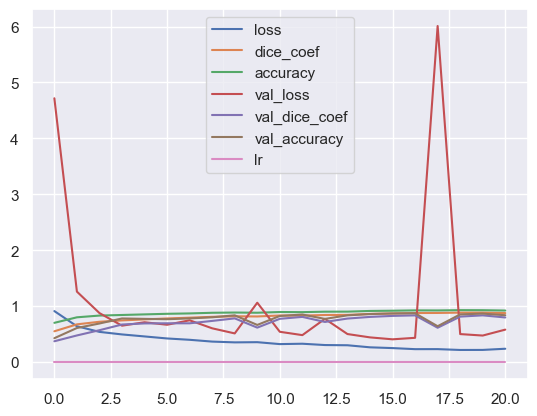

In [24]:
pd.DataFrame(history_inception.history).plot()

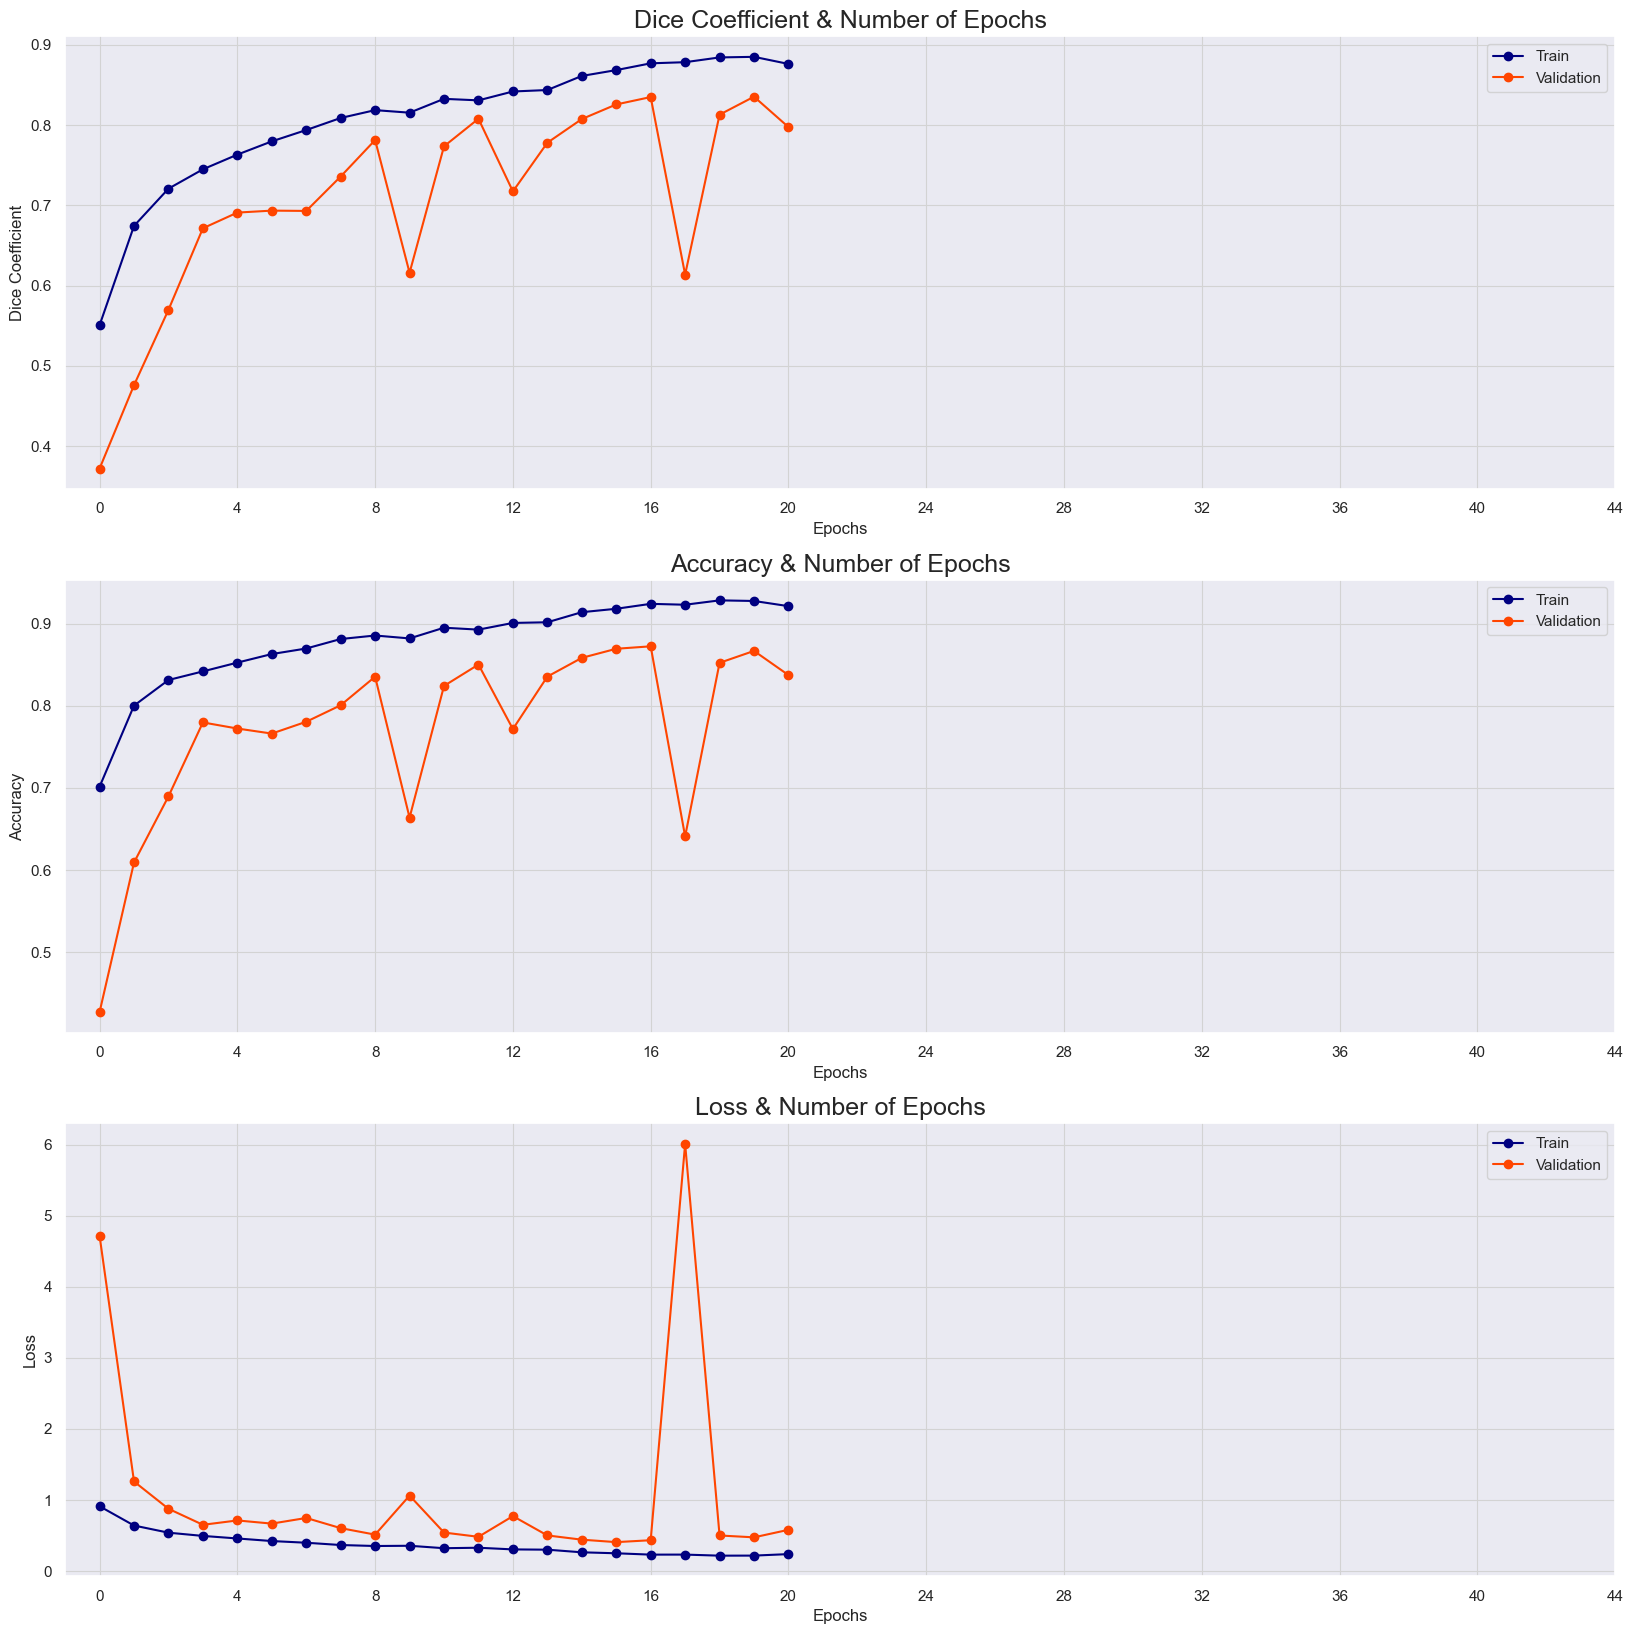

In [25]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_inception = ['Dice Coefficient', 'Accuracy', 'Loss']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss']): 
    ax[i].plot(history_inception.history[met], 'o-',color= 'navy')
    ax[i].plot(history_inception.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_inception[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_inception[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")   

In [26]:
y_pred_inception=model_inception.predict(X_test)

9/9 [==============================] - 40s 4s/step


# VGG19

In [17]:
# VGG19 model

def conv_block_VGG19(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def decoder_block_VGG19(inputs, skip_connection_input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_connection_input])
    x = conv_block_VGG19(x, num_filters)
    return x

In [18]:
def build_VGG19_unet(input_size,n_classes):
    inputs = Input(input_size)
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    # encoder 
    s1 = vgg19.get_layer("block1_conv2").output      # (256 x 256)
    s2 = vgg19.get_layer("block2_conv2").output      # (128 x 128)
    s3 = vgg19.get_layer("block3_conv4").output      # (64 x 64)
    s4 = vgg19.get_layer("block4_conv4").output      # (32 x 32)

    # bridge
    b1 = vgg19.get_layer("block5_conv4").output       # (16 x 16)

    # decoder
    d1 = decoder_block_VGG19(b1, s4, 256)                   
    d2 = decoder_block_VGG19(d1, s3, 128)                
    d3 = decoder_block_VGG19(d2, s2, 64)                    
    d4 = decoder_block_VGG19(d3, s1, 32)             
    
    # output
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_VGG19 = Model(inputs, outputs, name="VGG19-UNet")
    return model_VGG19

In [19]:
model_VGG19 = build_VGG19_unet((img_height, img_width, img_channels), n_classes)
model_VGG19.summary()

Model: "VGG19-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                        

In [20]:
# compile the model
model_VGG19.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])

checkpoint_VGG19 = ModelCheckpoint("./models/VGG19.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_VGG19 = EarlyStopping(monitor='val_accuracy', patience=20,verbose=1, restore_best_weights=True)
reduce_learningrate_VGG19 = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_VGG19 = [early_stopping_VGG19,checkpoint_VGG19,reduce_learningrate_VGG19]

c:\Users\D.azad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
history_VGG19 = model_VGG19.fit(X_train, y_train, batch_size = 32, verbose=1, epochs= 50, validation_data=(X_test, y_test), callbacks = callbacks_list_VGG19)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.6159 - dice_coef: 0.3068 - accuracy: 0.4214 
Epoch 1: val_accuracy improved from -inf to 0.47785, saving model to ./models\VGG19.h5
33/33 [==============================] - 1408s 42s/step - loss: 1.6159 - dice_coef: 0.3068 - accuracy: 0.4214 - val_loss: 1.9278 - val_dice_coef: 0.4101 - val_accuracy: 0.4778 - lr: 1.0000e-04
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 1.1602 - dice_coef: 0.4474 - accuracy: 0.6143 
Epoch 2: val_accuracy improved from 0.47785 to 0.65977, saving model to ./models\VGG19.h5
33/33 [==============================] - 1390s 42s/step - loss: 1.1602 - dice_coef: 0.4474 - accuracy: 0.6143 - val_loss: 1.4036 - val_dice_coef: 0.4513 - val_accuracy: 0.6598 - lr: 1.0000e-04
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.9730 - dice_coef: 0.5115 - accuracy: 0.7093 
Epoch 3: val_accuracy did not improve from 0.65977
33/33 [==============================] - 

In [22]:
df_result_VGG19 = pd.DataFrame(history_VGG19.history)
df_result_VGG19

,loss,dice_coef,accuracy,val_loss,val_dice_coef,val_accuracy,lr
0,1.615904,0.306771,0.421394,1.927830,0.410114,0.477848,0.000100
1,1.160170,0.447442,0.614323,1.403583,0.451343,0.659771,0.000100
2,0.972992,0.511500,0.709253,1.561055,0.471487,0.650505,0.000100
3,0.890567,0.547823,0.753166,1.098201,0.468351,0.668651,0.000100
4,0.841351,0.571958,0.772102,0.912373,0.520861,0.770081,0.000100
5,0.785019,0.592128,0.792403,0.753082,0.580889,0.811479,0.000100
6,0.749364,0.609856,0.803775,0.769046,0.568165,0.793602,0.000100
7,0.708589,0.626801,0.815935,0.784874,0.580194,0.773279,0.000100
8,0.684699,0.640968,0.824381,0.739170,0.598223,0.787051,0.000100
9,0.637699,0.658939,0.836974,0.689042,0.621059,0.802311,0.000100


In [23]:
# evalute model 
loss_VGG19,dice_loss_VGG19,acc_VGG19= model_VGG19.evaluate(X_test, y_test, verbose=1)
print("accuracy:", acc_VGG19)

9/9 [==============================] - 55s 6s/step - loss: 0.4122 - dice_coef: 0.7976 - accuracy: 0.8866
accuracy: 0.8866060972213745


<Axes: >

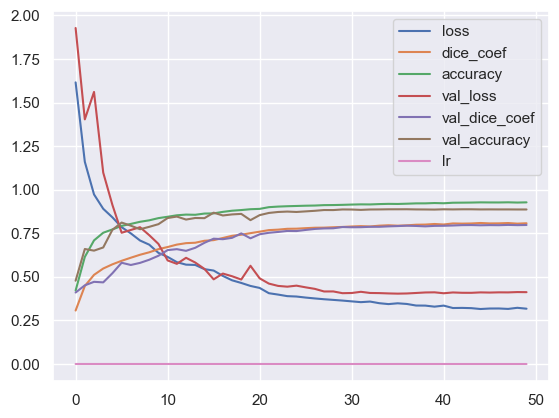

In [24]:
pd.DataFrame(history_VGG19.history).plot()

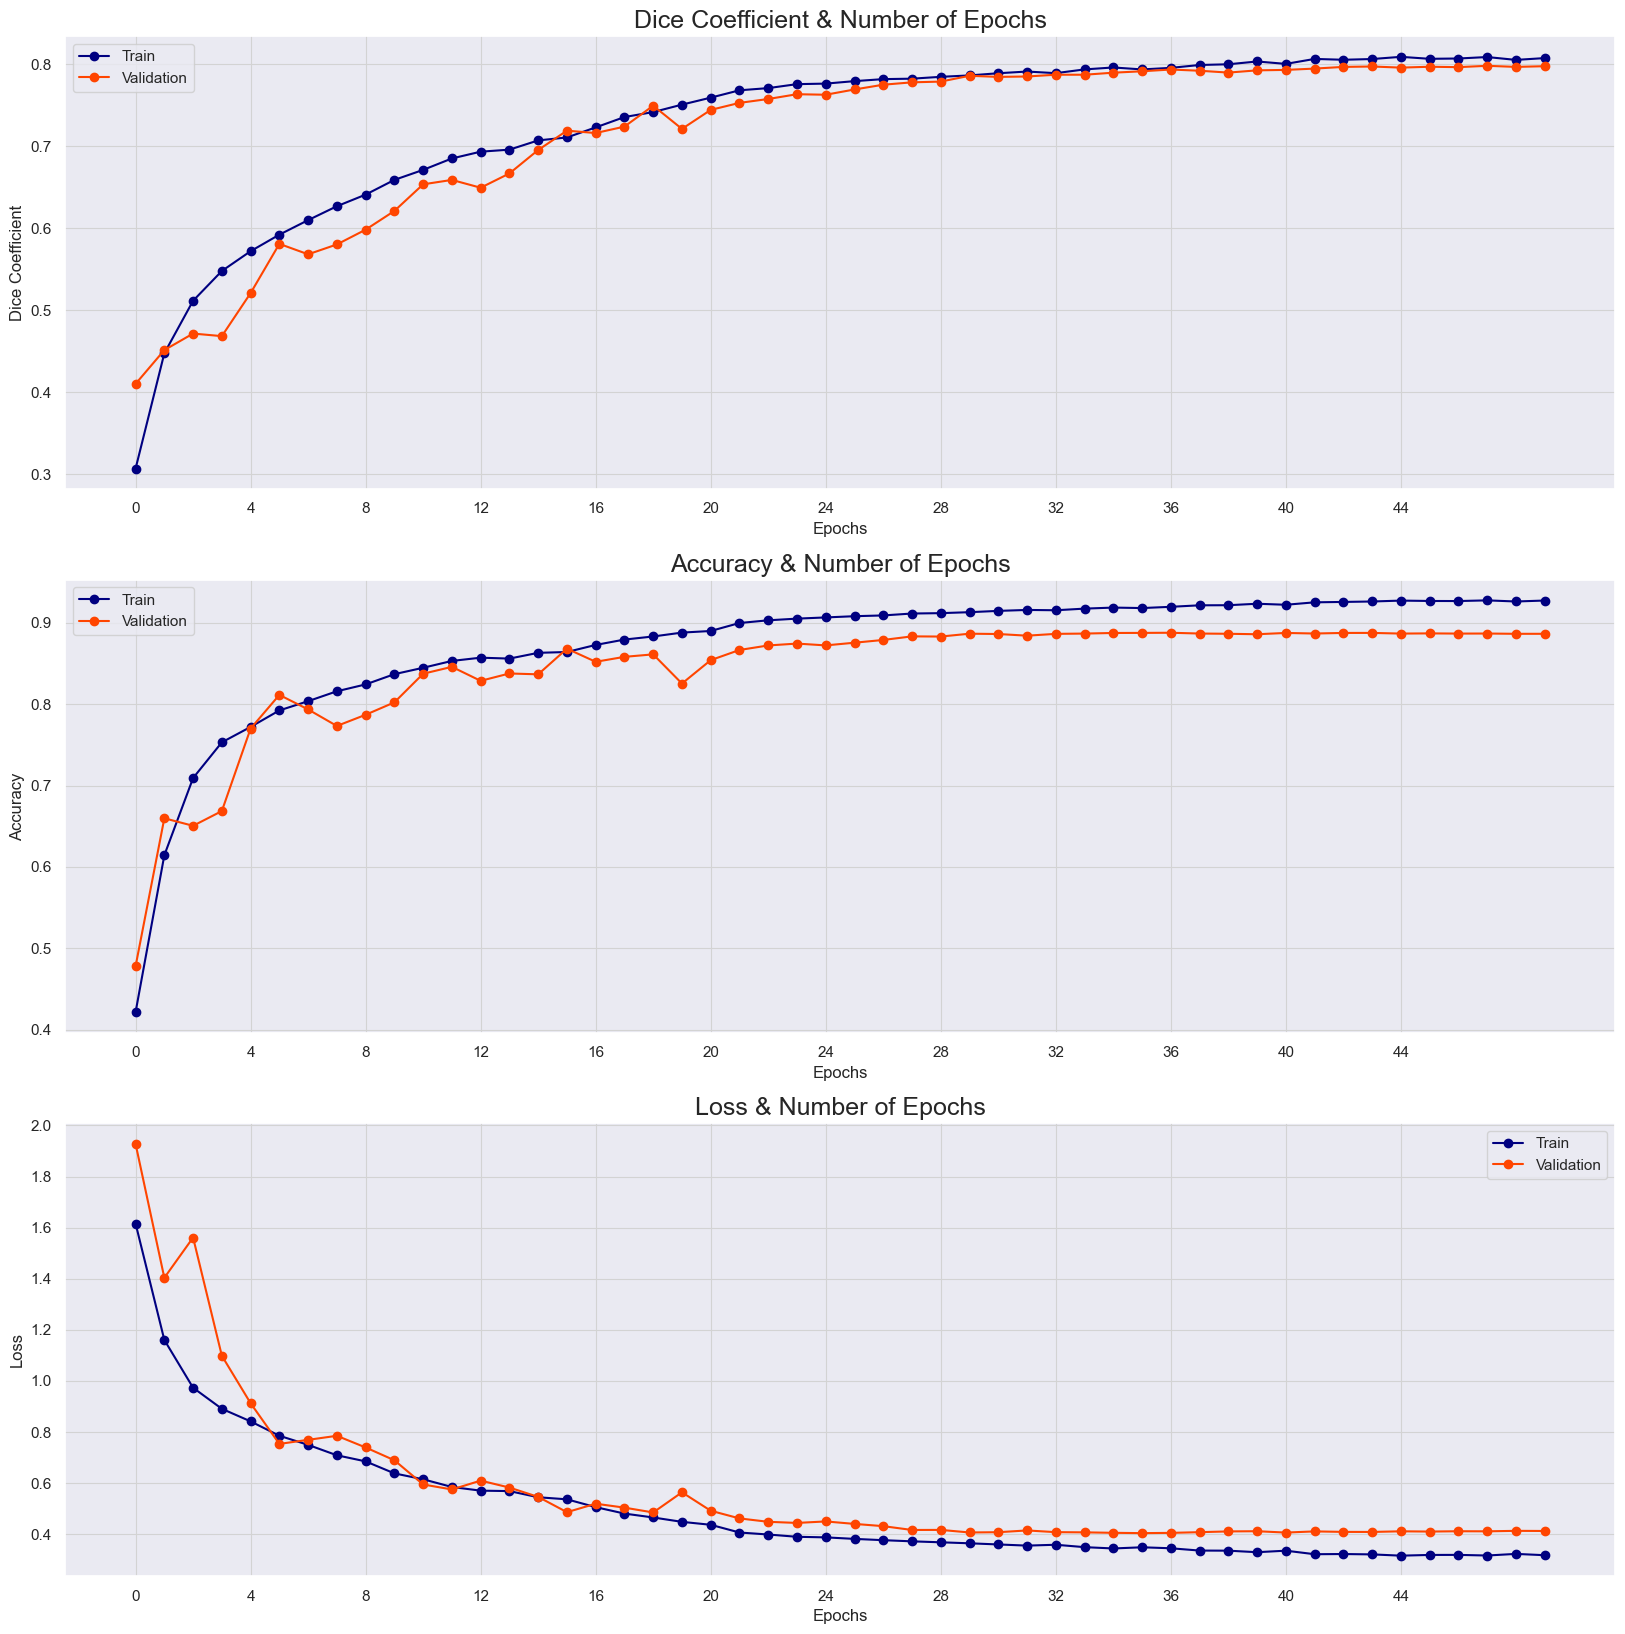

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
ax = ax.ravel()
metrics_VGG19 = ['Dice Coefficient', 'Accuracy', 'Loss']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss']): 
    ax[i].plot(history_VGG19.history[met], 'o-',color= 'navy')
    ax[i].plot(history_VGG19.history['val_' + met], 'o-',color= 'orangered')
    ax[i].set_title('{} & Number of Epochs'.format(metrics_VGG19[i]), fontsize=18)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(metrics_VGG19[i])
    ax[i].set_xticks(np.arange(0,46,4))
    ax[i].legend(['Train', 'Validation'])
    ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")   

In [27]:
y_pred_VGG19=model_VGG19.predict(X_test)

9/9 [==============================] - 55s 6s/step


In [28]:
model_VGG19.save("./models/VGG19_Unet.h5")

# EfficientNetB0

In [17]:
# EfficientNetB0 model

def conv_block_EfficientNet(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def decoder_block_EfficientNet(inputs, skip_connection_input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_connection_input])
    x = conv_block_EfficientNet(x, num_filters)
    return x

In [18]:
def build_EfficientNet_unet(input_size,n_classes):
    inputs = Input(input_size)
    efficientNet = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)

# encoder 
    s1 = efficientNet.get_layer("input_1").output                        # (256 x 256)
    s2 = efficientNet.get_layer("block2a_expand_activation").output      # (128 x 128)
    s3 = efficientNet.get_layer("block3a_expand_activation").output      # (64 x 64)
    s4 = efficientNet.get_layer("block4a_expand_activation").output      # (32 x 32)

    # bridge
    b1 = efficientNet.get_layer("block6a_expand_activation").output      # (16 x 16)

    # decoder
    d1 = decoder_block_EfficientNet(b1, s4, 256)                   
    d2 = decoder_block_EfficientNet(d1, s3, 128)                
    d3 = decoder_block_EfficientNet(d2, s2, 64)                    
    d4 = decoder_block_EfficientNet(d3, s1, 32)             
    
    # output
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(dropout)

    model_EfficientNet = Model(inputs, outputs, name="EfficientNetB0-UNet")
    return model_EfficientNet


In [19]:
model_EfficientNet = build_EfficientNet_unet((img_height, img_width, img_channels), n_classes)
model_EfficientNet.summary()

Model: "EfficientNetB0-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization

In [20]:
# compile the model
model_EfficientNet.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])

checkpoint_EfficientNet = ModelCheckpoint("./models/EfficientNetB0.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping_EfficientNet = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

reduce_learningrate_EfficientNet = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

callbacks_list_EfficientNet = [early_stopping_EfficientNet,checkpoint_EfficientNet,reduce_learningrate_EfficientNet]

c:\Users\D.azad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
history_EfficientNet = model_EfficientNet.fit(X_train, y_train, batch_size = 32, verbose=1, epochs= 50, validation_data=(X_test, y_test), callbacks = callbacks_list_EfficientNet)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.6681 - dice_coef: 0.2383 - accuracy: 0.3338 
Epoch 1: val_accuracy improved from -inf to 0.14628, saving model to ./models\EfficientNetB0.h5


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

# Result

In [28]:
# Comparision of (Acc)s and (Loss)s
y_pred_argmax_inception=np.argmax(y_pred_inception, axis=3)
y_pred_argmax_VGG19=np.argmax(y_pred_VGG19, axis=3)
y_test_argmax=np.argmax(y_test, axis=3) 

In [ ]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(epoch_count, val_loss_alex, '--bo',color= 'navy',
         linewidth = '2.5', label='line with marker')
plt.plot(epoch_count, val_loss_vgg, '--bo',color= 'orangered',
         linewidth = '2.5', label='line with marker')
plt.plot(epoch_count, val_loss_res, '--bo',color= 'black',
         linewidth = '2.5', label='line with marker')
plt.legend(['AlexNet', 'VGGNet','ResNet'])
plt.title('Number of epochs & Loss in All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,21,1))
plt.show();

In [ ]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(epoch_count, val_acc_alex, '--bo',color= 'navy',
         linewidth = '2.5', label='line with marker')
plt.plot(epoch_count, val_acc_vgg, '--bo',color= 'orangered',
         linewidth = '2.5', label='line with marker')
plt.plot(epoch_count, val_acc_res, '--bo',color= 'black',
         linewidth = '2.5', label='line with marker')
plt.legend(['AlexNet', 'VGGNet','ResNet'])
plt.title('Number of epochs & Accuracy in All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,21,1))
plt.show();

1/1 [==============================] - 0s 152ms/step


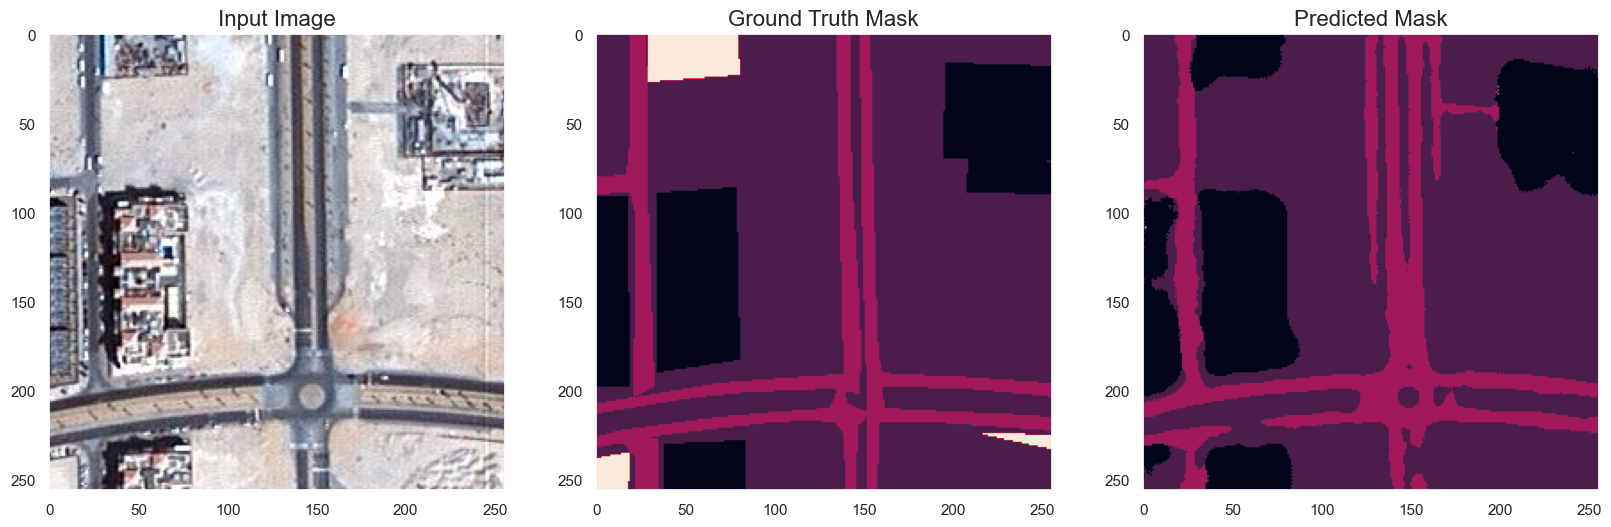

1/1 [==============================] - 0s 151ms/step


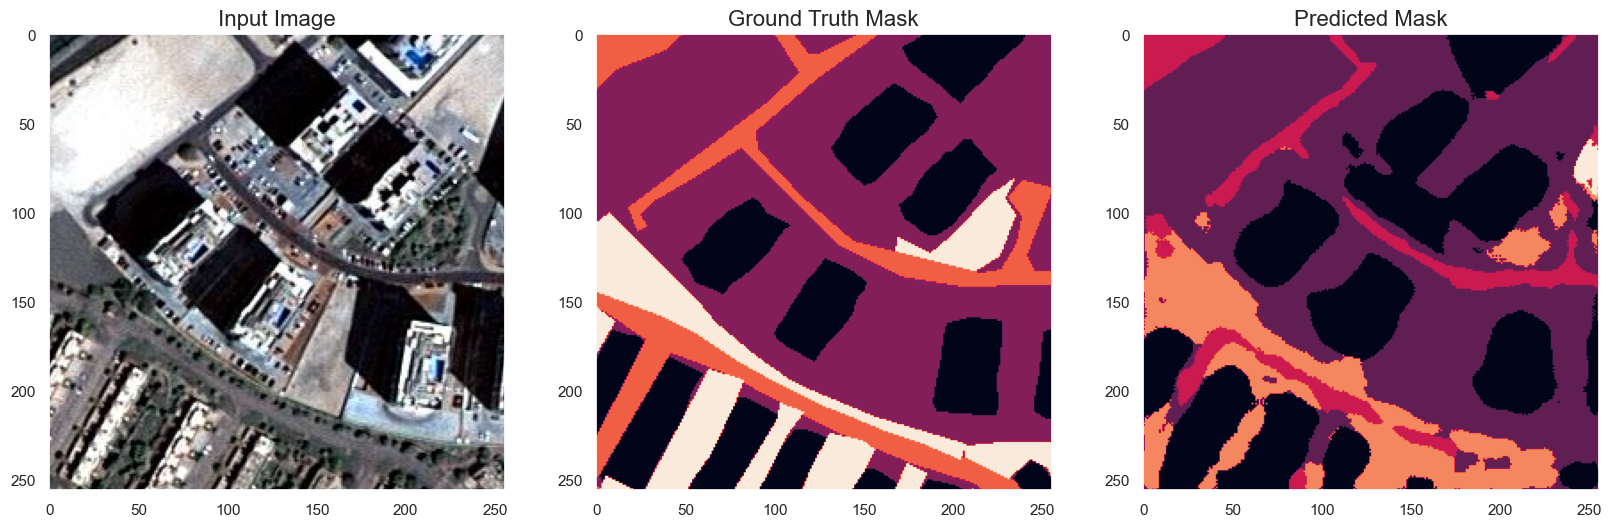

1/1 [==============================] - 0s 153ms/step


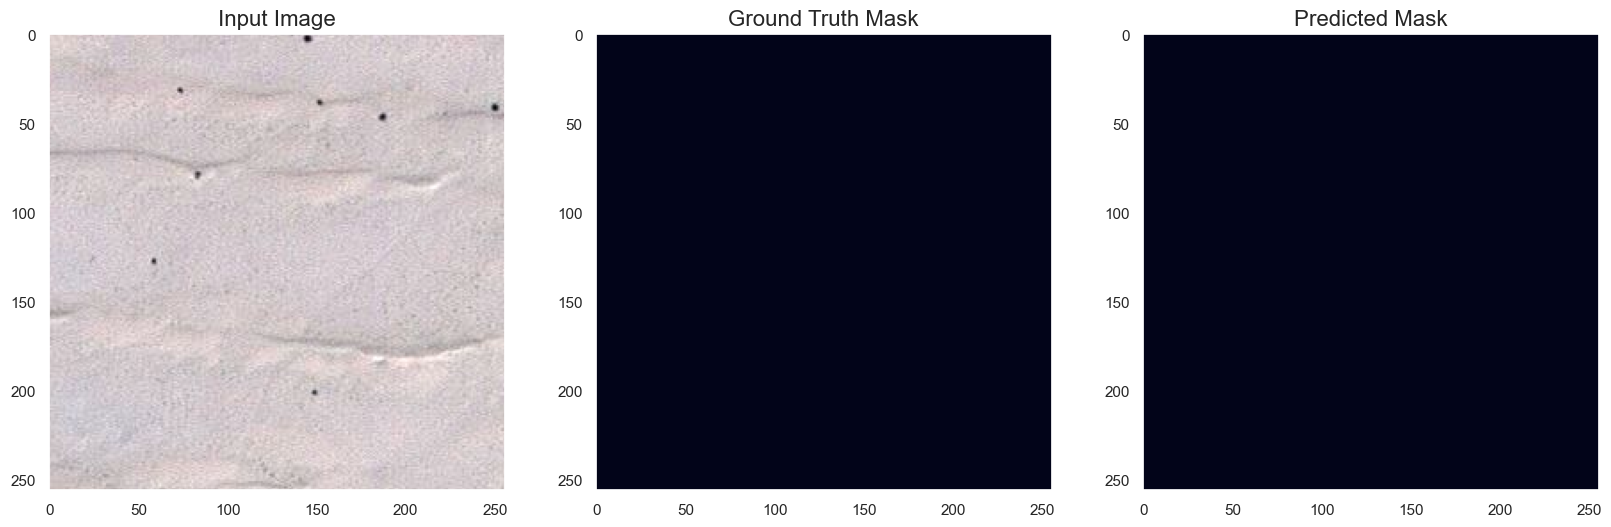

1/1 [==============================] - 0s 150ms/step


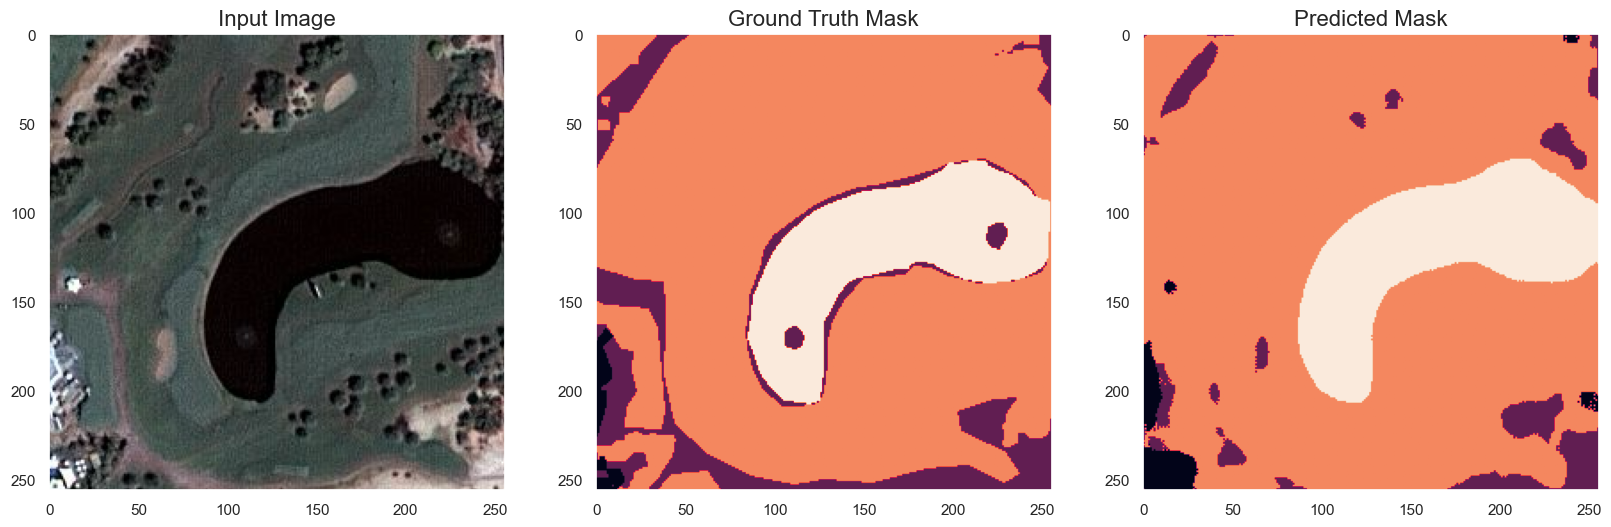

In [29]:
for i in range(4):
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(X_test[i])
    ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax1.grid(False)

    ax2 = fig.add_subplot(1,3,2)
    ax2.set_title('Ground Truth', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax2.imshow(y_test_argmax[i])
    ax2.grid(False)

    ax3 = fig.add_subplot(1,3,3)
    ax3.set_title('InceptionResNetV2-Unet Prediction', fontdict={'fontsize': 16, 'fontweight': 'medium'})
    ax3.imshow(np.argmax(model.predict(np.expand_dims(X_test[i], 0)), axis=3)[0,:,:])
    ax3.grid(False)
        
    plt.show()